# Bernstein-Vazirani Algorithm

> **The Bernstein-Vazirani (BV) algorithm** [\[1\]](#original-paper), [\[2\]](#BVWiki), introduced by Ethan Bernstein and Umesh Vazirani, is a fundamental quantum algorithm that addresses a special case of the <a href="https://github.com/Classiq/classiq-library/blob/main/algorithms/algebraic/hidden_shift/hidden_shift.ipynb">hidden-shift problem</a>. It employs the same functional circuit structure as the <a href="https://github.com/Classiq/classiq-library/blob/main/algorithms/deutsch_jozsa/deutsch_jozsa.ipynb">Deutsch-Jozsa algorithm</a> and achieves a linear speedup over its classical counterpart in the oracle query model. 
>
> The algorithm treats the following problem:
>
> - **Input:** A Boolean function $f: \{0,1\}^n \rightarrow \{0,1\}$ defined as $$f(x)\equiv (x\cdot a) \,\,\mod 2~~,$$ where $ \cdot$ refers to a bitwise dot operation, and $a$ is a binary string of length $n$.
> - **Promise:** 
> - **Output:** Returns the secret string $a$ with minimum inquiries of the function.
>
> **Complexity:** The quantum approach requires a single query call, therefore, the quantum complexity query is $O(1)$. In contrast,  Classically, the minimum inquiries of the function $f$ for determining the secret string is $n$: $f$ is called with these strings:
$$
\begin{aligned}
f(100\dots0) &= a_0~, \\
f(010\dots0) &= a_1~, \\
\vdots\\
f(00\dots01) &= a_{n-1}~,
\end{aligned}
$$
which reveals the secret string, one bit at a time. If one allows for randomness, the expected number of queries remains linear in $n$. >
>
> ---
>
> **Keywords:**  Hidden string problem, Foundational quantum algorithms, Oracle/Query complexity. 


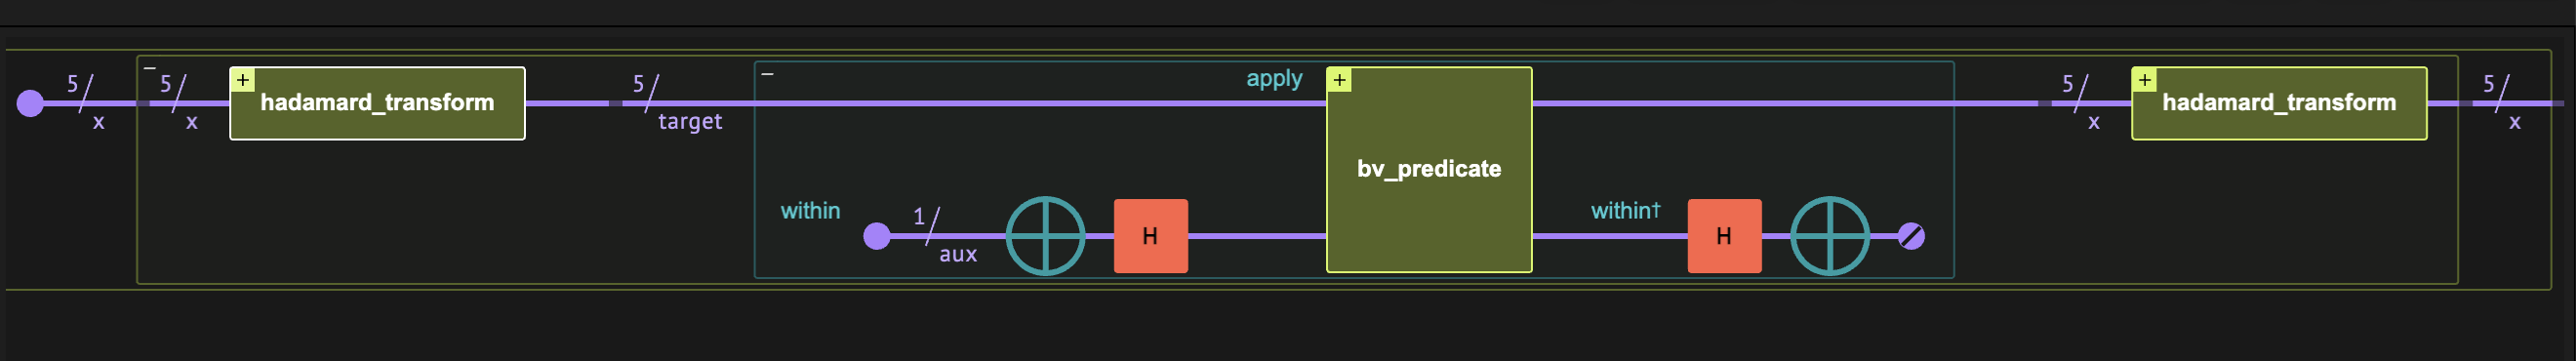
<center>
<figcaption align = "middle"> Figure 1. The Bernstein-Vazirani algorithm comprises three quantum blocks. The main part of the algorithm
is the implementation of the Bernstein-Vazirani predicate $f(x)\equiv (x\cdot a) \mod 2$. </figcaption>
</center>

## How to Build the Algorithm with Classiq

The BV algorithm contains three function blocks: an oracle for the predicate $f$, "sandwiched" between two Hadamard transforms. The resulting state corresponds to the secret string. The full [mathematical derivation](#Technical-Notes) is at the end of this notebook.

### Implementing the BV Predicate

A simple quantum implementation of the binary function $f(x)$ applies a series of controlled-X operations: starting with the state $|f\rangle=|0\rangle$, we apply an X gate, controlled on the $|x_i\rangle$ state, for all $i$ such that $a_i=1$:
$$
 |x_0\dots x_{n-1}\rangle |0\rangle_f \rightarrow \Pi_{i: a_i=1} {\rm CX}(x_i,f)  |x_0\dots x_{n-1}\rangle |0\rangle_f = |x_0\dots x_{n-1}\rangle X^{a\cdot x}|0\rangle_f=|x_0\dots x_{n-1}\rangle |a\cdot x \left(\text{ mod } 2\right)\rangle_f.
$$

In [1]:
from classiq import *
from classiq.qmod.symbolic import floor


@qperm
def bv_predicate(a: CInt, x: Const[QArray], res: QBit):
    repeat(
        x.len,
        lambda i: if_(floor(a / 2**i) % 2 == 1, lambda: CX(x[i], res)),
    )

Figure 2 shows an example of such implementation, for $a=01101$ and $n=5$.

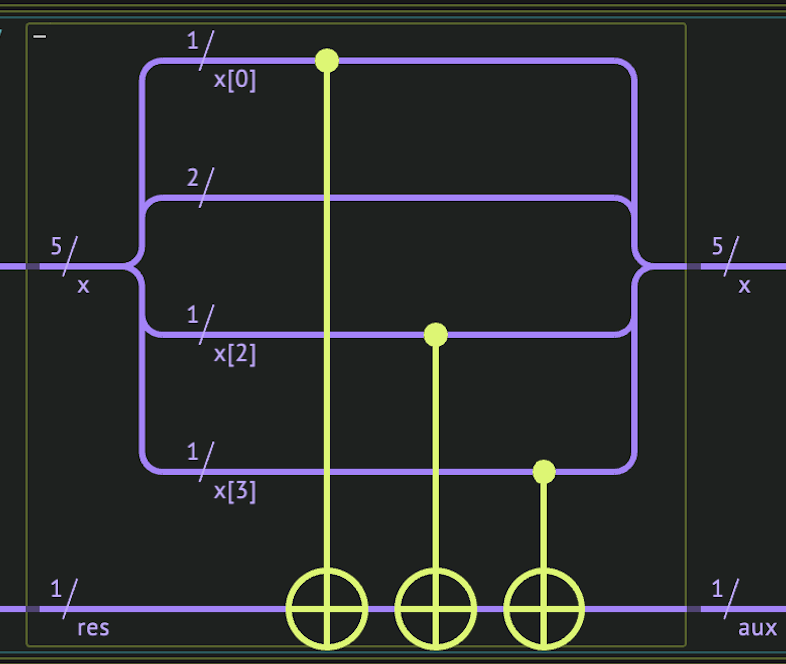
<center>
<figcaption align = "middle"> Figure 2. The Bernstein-Vazirani predicate $f(x)$ for a secret string $a=01101$, on $n$ qubits.
The quantum variable $x$ is stored on the five upper qubits and the resulting value of $f$ is on the lowermost qubit.</figcaption>
</center>

### Implementing the BV Quantum Function

The quantum part of the BV algorithm is essentially identical to the `deutsch_jozsa` function in the [Deutsch-Jozsa notebook](https://github.com/Classiq/classiq-library/blob/main/algorithms/deutsch_jozsa/deutsch_jozsa.ipynb). However, in contrast to the latter, the predicate function implementation is fixed, depending solely on the secret string $a$. Hereafter, we refer to the secret string as a secret integer, defined as an integer argument for the `bv_function`:

In [2]:
@qfunc
def bv_function(a: CInt, x: QArray):
    aux = QBit()
    within_apply(
        lambda: hadamard_transform(x),
        lambda: within_apply(
            lambda: (allocate(aux), X(aux), H(aux)), lambda: bv_predicate(a, x, aux)
        ),
    )

## An Example on Five Qubits

We construct a model for a specific example, setting the secret integer to $a=13$ and $n=5$.

The algorithm requires only a single application of the quantum circuit, as in an ideal noiseless execution, the resulting quantum state corresponds exactly to the hidden integer (see the last Eq. ([1](#mjx-eqn-1)) below). Even in the presence of noise, the idea of using only a single query call of $f$ has demonstrated algorithmic speedup in Ref. [[3](#ssBV)], where the authors considered a modified version of the BV algorithm in which the secret integer changes after every inquiry.

In this example, we take `num_shots=1000` to highlight the fact that the resulting state is purely the secret string.

In [3]:
import numpy as np

from classiq.execution import ExecutionPreferences

SECRET_INT = 13
STRING_LENGTH = 5
NUM_SHOTS = 1000
assert (
    np.floor(np.log2(SECRET_INT) + 1) <= STRING_LENGTH
), "The STRING_LENGTH cannot be smaller than secret string length"


@qfunc
def main(x: Output[QNum[STRING_LENGTH]]):
    allocate(x)
    bv_function(SECRET_INT, x)


write_qmod(main, "bernstein_vazirani")
qprog = synthesize(main)

We can now visualize the circuit:

In [4]:
show(qprog)

Quantum program link: https://platform.classiq.io/circuit/34kDHZcHQhQ2YaaFJJLVMsE8En4


We execute and extract the result:

In [5]:
result = execute(qprog).result_value()

In [6]:
secret_integer_q = result.dataframe["x"][0]


print("The secret integer is:", secret_integer_q)
print(
    "The probability for measuring the secret integer is:",
    result.dataframe["probability"][0],
)


assert int(secret_integer_q) == SECRET_INT

The secret integer is: 13
The probability for measuring the secret integer is: 1.0


## Technical Notes

Here is a brief summary of the linear algebra behind the Bernstein-Vazirani algorithm. The first Hadamard transformation generates an equal superposition over all the standard basis elements:
$$
|0\rangle_n \xrightarrow[H^{\otimes n}]{} \frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}|j\rangle_n.
$$
The oracle gets the Boolean Bernstein-Vazirani predicate and adds an $e^{\pi i}=-1$ phase to all states for which the function returns true:
$$
\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}|j\rangle_n \xrightarrow[\text{Oracle}(f(j))]{}\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}(-1)^{a\cdot j}|j\rangle_n.
$$
Finally, application of the Hadamard transform, which can be written as $H^{\otimes n}\equiv \frac{1}{2^{n/2}}\sum^{2^n-1}_{k,l=0}(-1)^{k\cdot l} |k\rangle \langle l| $, gives
$$
\frac{1}{2^{n/2}}\sum^{2^n-1}_{j=0}(-1)^{a\cdot j}|j\rangle  \xrightarrow[H^{\otimes n}]{}
\sum^{2^n-1}_{k=0} \left(\frac{1}{2^{n}}\sum^{2^n-1}_{j=0}(-1)^{j\cdot \left(k\oplus a \right)} \right) |k\rangle.
$$
The final expression represents a superposition over all basis states $|k\rangle$; however, we can verify that the amplitude of the state $|k\rangle=|a\rangle$ is simply one, as $a\oplus a =0$:
$$
\begin{equation*}
\left(\frac{1}{2^{n}}\sum^{2^n-1}_{j=0}1 \right) |a\rangle  + \sum^{2^n-1}_{k\neq a} 0 |k\rangle = |a\rangle.
\tag{1}
\end{equation*}
$$
Therefore, the final state is the secret string.

## References
<a id='original_paper'>[1]</a>: [Vazirani, Umesh, and E. Bernstein. Quantum complexity theory. Special issue on Quantum Computation of the Siam Journal of Computing 10 (1997)](https://epubs.siam.org/doi/10.1137/S0097539796300921)

<a id='BVWiki'>[2]</a>: [Bernstein–Vazirani (Wikipedia)](https://en.wikipedia.org/wiki/Bernstein%E2%80%93Vazirani_algorithm)

<a id='ssBV'>[3]</a>: [Pokharel B., and Daniel A. L. Demonstration of algorithmic quantum speedup. Physical Review Letters 130, 210602 (2023)](https://arxiv.org/abs/2207.07647)